In [1]:
pwd

In [2]:
import numpy as np
from numpy.random import seed 
seed(1) 
import pandas as pd
import tensorflow as tf
!pip install keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import random 

# Setting the seed for numpy-generated random numbers
np.random.seed(1234)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [3]:
# by default Keras's model.compile() sets the shuffle argument as True. You should the set numpy seed before importing keras. e.g.:

# import numpy as np
# np.random.seed(1337) # for reproducibility

In [4]:
# data to used for teaching time series

# data to used for teaching time series ie using the already preproceed data in order to save time.
data = pd.read_csv('select_stock.csv')
data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [5]:
#  Train Test Split

len(data)

6269

In [6]:
# convert columns to integers
data.columns.values

array(['date', 'spx', 'dax', 'ftse', 'nikkei'], dtype=object)

In [7]:
cols = ['spx', 'dax', 'ftse', 'nikkei']

In [8]:
for columns in cols:
    data[columns] = data[columns].astype(int)

In [9]:
data.head(5)

,date,spx,dax,ftse,nikkei
0,07/01/1994,469,2224,3445,18124
1,10/01/1994,475,2225,3440,18443
2,11/01/1994,474,2228,3413,18485
3,12/01/1994,474,2182,3372,18793
4,13/01/1994,472,2142,3360,18577


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269 entries, 0 to 6268
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    6269 non-null   object
 1   spx     6269 non-null   int32 
 2   dax     6269 non-null   int32 
 3   ftse    6269 non-null   int32 
 4   nikkei  6269 non-null   int32 
dtypes: int32(4), object(1)
memory usage: 147.1+ KB


In [11]:
data = data.drop(['dax','ftse','nikkei'],axis = 1)

In [12]:
data.head()

,date,spx
0,07/01/1994,469
1,10/01/1994,475
2,11/01/1994,474
3,12/01/1994,474
4,13/01/1994,472


In [13]:
# import datetime
from datetime import datetime

data.date = pd.to_datetime(data.date,dayfirst=True)
data.head(3)

,date,spx
0,1994-01-07,469
1,1994-01-10,475
2,1994-01-11,474


In [14]:
data.set_index('date',inplace = True)

In [15]:
data.head(3)

,spx
date,
1994-01-07,469
1994-01-10,475
1994-01-11,474


<AxesSubplot:xlabel='date'>

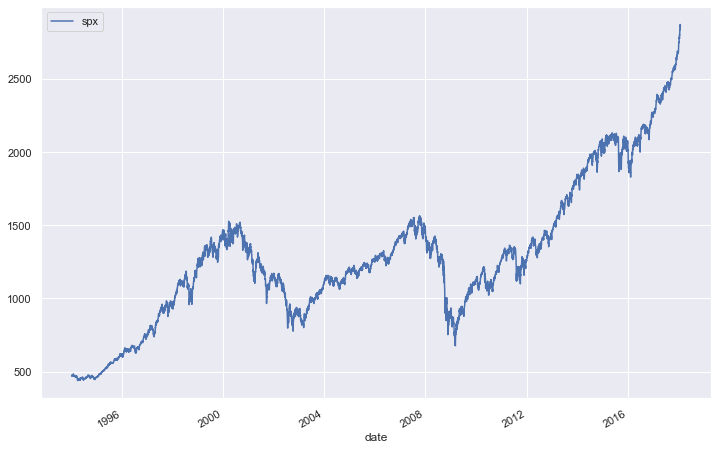

In [16]:
data.plot(figsize= (12,8))

In [17]:
len(data)

6269

In [18]:
train_len = len(data)-14

In [19]:
train = data.iloc[:train_len]
test=data.iloc[train_len:]

In [20]:
len(test)

14

In [21]:
# TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

# RNN uses weight and bias and so need to be of the same scale. minmaxscaler

from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()

In [23]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET

scaler.fit(train)

MinMaxScaler()

In [24]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [25]:
# Time Series Generator

# TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The n_input is up to you, but at a minimum it should be at least 12.**

from keras.preprocessing.sequence import TimeseriesGenerator

In [26]:
n_input = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [27]:
len(scaled_train)

6255

In [28]:
len(scaled_test)

14

In [29]:
len(generator)

6243

In [30]:
# ie 6264 - 24 = 6233

In [31]:
scaled_train[:6]

array([[0.01340251],
       [0.01599654],
       [0.0155642 ],
       [0.0155642 ],
       [0.01469952],
       [0.0155642 ]])

In [32]:
x,y = generator[0]

In [33]:
x

array([[[0.01340251],
        [0.01599654],
        [0.0155642 ],
        [0.0155642 ],
        [0.01469952],
        [0.0155642 ],
        [0.01513186],
        [0.0155642 ],
        [0.0155642 ],
        [0.0155642 ],
        [0.0155642 ],
        [0.01426719]]])

In [34]:
y

array([[0.01383485]])

In [35]:
x.shape, y.shape

((1, 12, 1), (1, 1))

In [36]:
# check first 2 of your scaled_train & compare with x, also see if the predicted y is close to corresponding x

In [37]:
### Create the Model

# TASK: Create a Keras Sequential Model with as many LSTAM units you want and a final Dense Layer.**

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
Early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=2)

In [39]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [41]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [42]:
# fit model
# multiprocessing=False  in methods like fit_generator
model.fit_generator(generator,callbacks=[Early_stopping],validation_data = validation_generator,epochs=30,shuffle = False)

Epoch 1/30


C:\Users\Henry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1879: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6243/6243 [==============================] - 16s 2ms/step - loss: 1.0171e-04 - val_loss: 0.0010
Epoch 2/30
6243/6243 [==============================] - 14s 2ms/step - loss: 0.0039 - val_loss: 8.2891e-04
Epoch 3/30
6243/6243 [==============================] - 15s 2ms/step - loss: 0.0023 - val_loss: 5.7825e-04
Epoch 4/30
6243/6243 [==============================] - 15s 2ms/step - loss: 0.0013 - val_loss: 1.7582e-04
Epoch 5/30
6243/6243 [==============================] - 14s 2ms/step - loss: 0.0011 - val_loss: 1.8617e-04
Epoch 6/30
6243/6243 [==============================] - 14s 2ms/step - loss: 7.8322e-04 - val_loss: 1.6464e-04
Epoch 7/30
6243/6243 [==============================] - 14s 2ms/step - loss: 5.3380e-04 - val_loss: 1.7235e-04
Epoch 8/30
6243/6243 [==============================] - 14s 2ms/step - loss: 4.7376e-04 - val_loss: 1.9143e-04


In [43]:
# **TASK: Plot the history of the loss that occured during training.**

model.history.history.keys()

dict_keys(['loss', 'val_loss'])

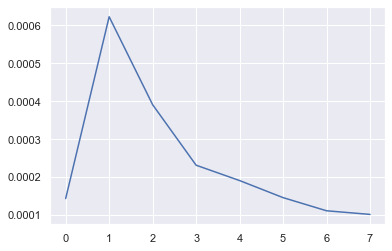

In [44]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [45]:
## Evaluate on Test Data

# TASK: Based on your test data and input size, create an appropriate;y sized "first evaluation batch"

first_eval_batch = scaled_train[-12:]

In [46]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [47]:
# **TASK: Generate predictions into the same time stamps as the test set**

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [48]:
test_predictions

[array([1.0066931], dtype=float32),
 array([1.012774], dtype=float32),
 array([1.016526], dtype=float32),
 array([1.0185823], dtype=float32),
 array([1.0195427], dtype=float32),
 array([1.0199268], dtype=float32),
 array([1.0200438], dtype=float32),
 array([1.0200598], dtype=float32),
 array([1.0200438], dtype=float32),
 array([1.0200254], dtype=float32),
 array([1.0200117], dtype=float32),
 array([1.0200019], dtype=float32),
 array([1.019997], dtype=float32),
 array([1.0199965], dtype=float32)]

In [49]:
## Inverse Transformations and Compare

## TASK: Inverse Transform your new forecasted predictions.**


true_predictions_new = scaler.inverse_transform(test_predictions)

In [50]:
# IGNORE WARNINGS
test['Predictions'] =true_predictions_new

<ipython-input-50-b21e09998b6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] =true_predictions_new


In [51]:
test.head(12)

,spx,Predictions
date,,
2018-01-10,2748,2766.481198
2018-01-11,2767,2780.546240
2018-01-12,2786,2789.224601
2018-01-15,2786,2793.980962
2018-01-16,2776,2796.202251
2018-01-17,2802,2797.090657
2018-01-18,2798,2797.361425
2018-01-19,2810,2797.398373
2018-01-22,2832,2797.361425


<AxesSubplot:xlabel='date'>

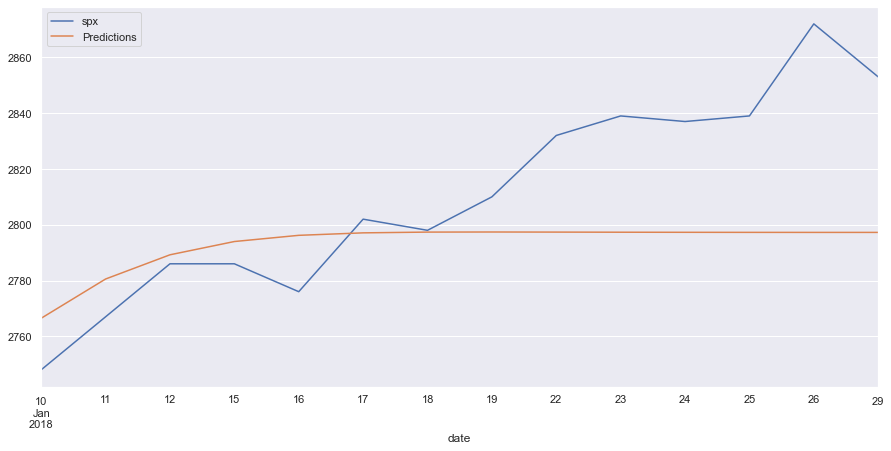

In [52]:
test.plot(figsize=(15,7))


In [53]:
test.shape, true_predictions_new.shape

((14, 2), (14, 1))

In [54]:
test.head()

,spx,Predictions
date,,
2018-01-10,2748,2766.481198
2018-01-11,2767,2780.546240
2018-01-12,2786,2789.224601
2018-01-15,2786,2793.980962
2018-01-16,2776,2796.202251


In [55]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

print(np.sqrt(mean_squared_error(test.spx,true_predictions_new)))

33.95552666298609


In [56]:
model.save('solutions_model.h5')

In [57]:
from sklearn.metrics import r2_score

In [58]:
print(r2_score(test.spx,true_predictions_new))

0.0389113947072135


In [59]:
# to make future forcast
full_scaler = MinMaxScaler()

In [60]:
# forcasting with full data set
scaled_full_data = full_scaler.fit_transform(data)

In [61]:
n_input = 12

In [62]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=n_input, batch_size=1)

In [63]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [64]:

model.fit_generator(generator,epochs=8,shuffle = False)

Epoch 1/8


C:\Users\Henry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1879: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6257/6257 [==============================] - 14s 2ms/step - loss: 8.6400e-05
Epoch 2/8
6257/6257 [==============================] - 13s 2ms/step - loss: 0.0034
Epoch 3/8
6257/6257 [==============================] - 13s 2ms/step - loss: 0.0017
Epoch 4/8
6257/6257 [==============================] - 13s 2ms/step - loss: 0.0012
Epoch 5/8
6257/6257 [==============================] - 13s 2ms/step - loss: 8.2026e-04
Epoch 6/8
6257/6257 [==============================] - 13s 2ms/step - loss: 7.2434e-04
Epoch 7/8
6257/6257 [==============================] - 14s 2ms/step - loss: 5.0616e-04
Epoch 8/8
6257/6257 [==============================] - 14s 2ms/step - loss: 4.2766e-04


In [65]:
# **TASK: Generate predictions into the same time stamps as the test set**

forcast = []

first_eval_batch = scaled_full_data[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forcast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [66]:
forcast

[array([0.99360013], dtype=float32),
 array([0.9975561], dtype=float32),
 array([1.0016099], dtype=float32),
 array([1.0049272], dtype=float32),
 array([1.0072013], dtype=float32),
 array([1.0085138], dtype=float32),
 array([1.0091089], dtype=float32),
 array([1.0092634], dtype=float32),
 array([1.009213], dtype=float32),
 array([1.0090965], dtype=float32),
 array([1.0090111], dtype=float32),
 array([1.0089635], dtype=float32),
 array([1.0089513], dtype=float32),
 array([1.0089629], dtype=float32)]

In [67]:
true_forcast = scaler.inverse_transform(forcast)

In [68]:
true_forcast

array([[2736.19710088],
       [2745.34723699],
       [2754.72374833],
       [2762.39651728],
       [2767.65663922],
       [2770.69243848],
       [2772.06888807],
       [2772.42623556],
       [2772.30960131],
       [2772.04021204],
       [2771.84278858],
       [2771.73249614],
       [2771.70437157],
       [2771.73111749]])

In [69]:
data.tail(10)

,spx
date,
2018-01-16,2776
2018-01-17,2802
2018-01-18,2798
2018-01-19,2810
2018-01-22,2832
2018-01-23,2839
2018-01-24,2837
2018-01-25,2839
2018-01-26,2872


In [70]:
# convert z to dataframe
forcast_index = pd.date_range('2018-01-29', periods=14, freq='b')
forcast_index

DatetimeIndex(['2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-05', '2018-02-06', '2018-02-07',
               '2018-02-08', '2018-02-09', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15'],
              dtype='datetime64[ns]', freq='B')

In [71]:
true_forcast = pd.DataFrame(data = true_forcast,index =forcast_index,columns = ['forcast'])
true_forcast

,forcast
2018-01-29,2736.197101
2018-01-30,2745.347237
2018-01-31,2754.723748
2018-02-01,2762.396517
2018-02-02,2767.656639
2018-02-05,2770.692438
2018-02-06,2772.068888
2018-02-07,2772.426236
2018-02-08,2772.309601
2018-02-09,2772.040212


(12538.0, 12552.0)

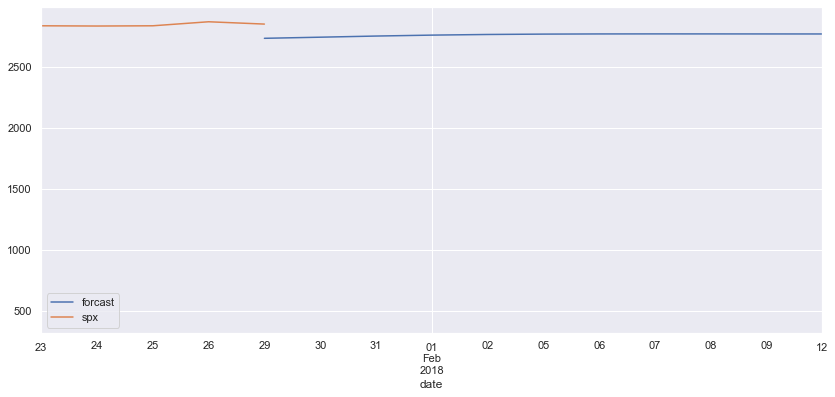

In [72]:
ax =true_forcast.plot(legend=True,figsize =(14,6))
data.plot(ax = ax)
plt.xlim('2018-01-23','2018-02-12')